### Big Data Analytics Framework for Efficient Management & Preservation of Digital Archives & Libraries

**Libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install opencv-python --index-url=https://pypi.python.org/simple/

Looking in indexes: https://pypi.python.org/simple/


In [3]:
!pip install moviepy 

In [4]:
!pip install SpeechRecognition

In [5]:
!pip install pydub

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import shutil
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

**Data Sorting**

In [7]:
def categorize_and_move_files(directory_path):
    # Define folder names
    video_folder = 'videos'
    pdf_folder = 'pdfs'
    images_folder = 'images'
    unclassified_folder = 'unclassified'

    # Create folders if they don't exist
    folders = [video_folder, pdf_folder, images_folder, unclassified_folder]
    for folder in folders:
        folder_path = os.path.join(directory_path, folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)

        # Check if it's a file
        if os.path.isfile(file_path):
            # Get the file extension
            _, file_extension = os.path.splitext(filename)

            # Categorize files based on extension
            if file_extension.lower() in ['.mp4', '.avi', '.mkv', '.dat']:
                destination_folder = video_folder
            elif file_extension.lower() == '.pdf':
                destination_folder = pdf_folder
            elif file_extension.lower() in ['.jpg', '.jpeg', '.png', '.gif']:
                destination_folder = images_folder
            else:
                destination_folder = unclassified_folder

            # Move the file to the corresponding folder
            destination_path = os.path.join(directory_path, destination_folder, filename)
            shutil.move(file_path, destination_path)
            print(f"Moved {filename} to {destination_folder} folder.")

            
directory_path = './data'
categorize_and_move_files(directory_path)


**Video Data Reading/Analysis**

In [8]:
# Function to get video information
def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    
    # Get number of frames and resolution
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    resolution = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    # Calculate duration using number of frames and frame rate
    duration = num_frames / frame_rate if frame_rate > 0 else 0
    # Get codec information
    codec_fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    codec = chr(codec_fourcc & 0xFF) + chr((codec_fourcc & 0xFF00) >> 8) + chr((codec_fourcc & 0xFF0000) >> 16) + chr((codec_fourcc & 0xFF000000) >> 24)


    cap.release()

    return num_frames, resolution, duration, frame_rate, codec

In [9]:
# Directory path
directory_path = './data/videos'

# Ensure the directory path is valid
if not os.path.isdir(directory_path):
    print("Invalid directory path.")
else:
    # Initialize an empty list to store file information
    file_info_list = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)

        # Check if it's a file
        if os.path.isfile(file_path):
            # Extract filename, extension, and filepath
            file_info = {
                'filename': os.path.splitext(filename)[0],  # Store filename without extension
                'extension': os.path.splitext(filename)[1],
                'filepath': os.path.normpath(file_path)  # Normalize file path
            }
            # Get video information
            num_frames, resolution, duration, frame_rate, codec = get_video_info(file_path)
            file_info['num_frames'] = num_frames
            file_info['resolution'] = resolution
            file_info['duration'] = duration
            file_info['frame_rate'] = frame_rate
            file_info['codec'] = codec

            
            
            file_info_list.append(file_info)

    # Create a DataFrame from the list of file information
    video_file_info_df = pd.DataFrame(file_info_list)


In [10]:
# Display the DataFrame
video_file_info_df.head(10)

,filename,extension,filepath,num_frames,resolution,duration,frame_rate,codec
0,AVSEQ01,.DAT,data\videos\AVSEQ01.DAT,14487,"(352, 288)",579.4800,25.00000,mpg1
1,AVSEQ02,.DAT,data\videos\AVSEQ02.DAT,7067,"(352, 288)",282.6800,25.00000,mpg1
2,AVSEQ03,.DAT,data\videos\AVSEQ03.DAT,10426,"(352, 288)",417.0400,25.00000,mpg1
3,AVSEQ04,.DAT,data\videos\AVSEQ04.DAT,8116,"(352, 288)",324.6400,25.00000,mpg1
4,chief olusegun obasanjo free health program (C...,.mp4,data\videos\chief olusegun obasanjo free healt...,126012,"(854, 480)",4204.6004,29.97003,h264
5,media chat 1,.mp4,data\videos\media chat 1.mp4,22503,"(720, 576)",900.1200,25.00000,h264
6,media chat 4,.mp4,data\videos\media chat 4.mp4,20496,"(720, 576)",819.8400,25.00000,h264


**Data Extraction From Files**

In [11]:
from moviepy.editor import VideoFileClip
import speech_recognition as sr
import tempfile
from pydub import AudioSegment


# Function to extract audio from video file using moviepy
def extract_audio(video_file):
    video_clip = VideoFileClip(video_file)
    audio_clip = video_clip.audio
    return audio_clip

def chunk_audio_and_save(audio_path, chunk_length=5000):  # chunk_length in milliseconds
    audio = AudioSegment.from_wav(audio_path)
    length_audio = len(audio)
    chunk_paths = []
    for i, chunk in enumerate(range(0, length_audio, chunk_length)):
        chunk_audio = audio[chunk:chunk + chunk_length]
        chunk_path = f"./temp_chunk_{i}.wav"
        chunk_audio.export(chunk_path, format="wav")
        chunk_paths.append(chunk_path)
    return chunk_paths

# Function to convert audio to text using SpeechRecognition
def audio_to_text(filename, audio_file):
    audio_file_name = f'./audio/{filename}.wav'
    audio_file.write_audiofile(audio_file_name)
    chunk_file_paths = chunk_audio_and_save(audio_file_name)
    # Initialize recognizer 
    r = sr.Recognizer() 
    text = ""
    
    for i, file_path in enumerate(chunk_file_paths):
        print(f"Transcribing chunk {i+1}/{len(chunk_file_paths)}...")
        # Load the audio file 
        with sr.AudioFile(file_path) as source: 
            data = r.record(source) 

        # Convert speech to text 
        part_text = r.recognize_google(data)
        text += part_text
        os.remove(file_path)  # Clean up chunk file

    return text

# Iterate through each row in the DataFrame
for index, row in video_file_info_df.iterrows():
    # Check if it's a video file (.mp4, .dat)
    if row['extension'].lower() in ['.mp4', '.dat']:
        try:
            video_path = "./" + row['filepath'].replace('\\', '/')
            print(video_path)
            # Extract audio from video
            audio_clip = extract_audio(video_path)

            # Convert audio to text
            audio_text = audio_to_text(row['filename'], audio_clip)

            # Update 'audio_text' column in the DataFrame
            video_file_info_df.at[index, 'audio_text'] = audio_text
        except Exception as e:
            print(f"Error processing {row['filename']}: {e}")


./data/videos/AVSEQ01.DAT
MoviePy - Writing audio in ./audio/AVSEQ01.wav


MoviePy - Done.
Transcribing chunk 1/116...
Error processing AVSEQ01: 
./data/videos/AVSEQ02.DAT
MoviePy - Writing audio in ./audio/AVSEQ02.wav


MoviePy - Done.
Transcribing chunk 1/57...
Error processing AVSEQ02: 
./data/videos/AVSEQ03.DAT
MoviePy - Writing audio in ./audio/AVSEQ03.wav


MoviePy - Done.
Transcribing chunk 1/84...
Error processing AVSEQ03: 
./data/videos/AVSEQ04.DAT
MoviePy - Writing audio in ./audio/AVSEQ04.wav


MoviePy - Done.
Transcribing chunk 1/65...
Error processing AVSEQ04: 
./data/videos/chief olusegun obasanjo free health program (COOFEHEP.mp4
MoviePy - Writing audio in ./audio/chief olusegun obasanjo free health program (COOFEHEP.wav


MoviePy - Done.
Transcribing chunk 1/841...
Error processing chief olusegun obasanjo free health program (COOFEHEP: 
./data/videos/media chat 1.mp4
MoviePy - Writing audio in ./audio/media chat 1.wav


MoviePy - Done.
Transcribing chunk 1/181...
Error processing media chat 1: 
./data/videos/media chat 4.mp4
MoviePy - Writing audio in ./audio/media chat 4.wav


MoviePy - Done.
Transcribing chunk 1/165...
Transcribing chunk 2/165...
Transcribing chunk 3/165...
Transcribing chunk 4/165...
Error processing media chat 4: 


In [12]:
# Display the updated DataFrame
video_file_info_df.head()

,filename,extension,filepath,num_frames,resolution,duration,frame_rate,codec
0,AVSEQ01,.DAT,data\videos\AVSEQ01.DAT,14487,"(352, 288)",579.4800,25.00000,mpg1
1,AVSEQ02,.DAT,data\videos\AVSEQ02.DAT,7067,"(352, 288)",282.6800,25.00000,mpg1
2,AVSEQ03,.DAT,data\videos\AVSEQ03.DAT,10426,"(352, 288)",417.0400,25.00000,mpg1
3,AVSEQ04,.DAT,data\videos\AVSEQ04.DAT,8116,"(352, 288)",324.6400,25.00000,mpg1
4,chief olusegun obasanjo free health program (C...,.mp4,data\videos\chief olusegun obasanjo free healt...,126012,"(854, 480)",4204.6004,29.97003,h264


**Image Data Reading/Analysis**

In [13]:
!pip install pytesseract

In [14]:
import pytesseract
from PIL import Image

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


In [15]:
# Function to calculate image noise 
def calculate_noise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    noise = cv2.meanStdDev(gray)[1][0]
    return noise

In [16]:
# Function to get dominant color
def get_dominant_color(image):
    # Reshape image to a list of pixels
    pixels = image.reshape((-1, 3))

    # Calculate histogram
    hist = np.histogramdd(pixels, bins=(256, 256, 256), range=[(0, 256), (0, 256), (0, 256)])[0]

    # Find the dominant color
    dominant_color = np.unravel_index(np.argmax(hist), hist.shape)

    return dominant_color

In [17]:
# Function to extract text using OCR
def extract_text(image_path):
    # Read the image using Pillow (PIL)
    img_pil = Image.open(image_path)

    # Perform OCR using Tesseract
    text = pytesseract.image_to_string(img_pil)

    return text

In [18]:
# Function to get image information
def get_image_info(image_path):
    img = cv2.imread(image_path)

    # Get basic image information
    filename = os.path.splitext(os.path.basename(image_path))[0]
    extension = os.path.splitext(image_path)[1]
    resolution = img.shape[:2]
    num_pixels = img.size
    is_grayscale = len(img.shape) < 3
    noise = calculate_noise(img)
    size = os.path.getsize(image_path)
    
    mean_intensity = img.mean()
    std_intensity = img.std()
    min_intensity = img.min()
    max_intensity = img.max()
    
    # Color channels
    num_channels = img.shape[2] if len(img.shape) == 3 else 1

    # Dominant color
    dominant_color = get_dominant_color(img)

    # Aspect ratio
    aspect_ratio = resolution[0] / resolution[1] if resolution[1] != 0 else 0
    
    # Extract text using OCR
    text = extract_text(image_path)

    return {
        'filename': filename,
        'extension': extension,
        'filepath': os.path.normpath(image_path),
        'resolution': resolution,
        'num_pixels': num_pixels,
        'is_grayscale': is_grayscale,
        'noise': noise,
        'size': size,
        'mean_intensity': mean_intensity,
        'std_intensity': std_intensity,
        'min_intensity': min_intensity,
        'max_intensity': max_intensity,
        'num_channels': num_channels,
        'dominant_color': dominant_color,
        'aspect_ratio': aspect_ratio,
        'text': text
    }

In [19]:
# Directory path
directory_path = './data/images'

# Ensure the directory path is valid
if not os.path.isdir(directory_path):
    print("Invalid directory path.")
else:
    # Initialize an empty list to store file information
    file_info_list = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)

        # Check if it's an image file
        if os.path.isfile(image_path) and any(image_path.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.gif']):
            # Get image information
            image_info = get_image_info(image_path)
            file_info_list.append(image_info)

    # Create a DataFrame from the list of file information
    image_file_info_df = pd.DataFrame(file_info_list)


In [20]:
# Display the DataFrame
image_file_info_df.head()

,filename,extension,filepath,resolution,num_pixels,is_grayscale,noise,size,mean_intensity,std_intensity,min_intensity,max_intensity,num_channels,dominant_color,aspect_ratio,text
0,0001,.jpg,data\images\0001.jpg,"(2955, 2000)",17730000,False,[29.55783589969031],589465,202.173847,38.261689,0,-1,3,"(167, 217, 240)",1.477500,"a\n\nas , HISTORM oO F) AR! (ttME 7. ‘N\n\n——\..."
1,baba's browser page,.jpeg,data\images\baba's browser page.jpeg,"(177, 284)",150804,False,[23.867786693629224],6542,241.298918,24.138366,0,-1,3,"(255, 255, 255)",0.623239,
2,High Court of Lagos State Holden at Lagos on D...,.jpg,data\images\High Court of Lagos State Holden a...,"(3875, 2346)",27272250,False,[28.76593228829025],825542,208.957622,32.867835,0,-1,3,"(193, 229, 235)",1.651748,J ) :\n‘ IN THE HIGH COURT OF LAGOS STATE =\n\...
3,land document,.jpeg,data\images\land document.jpeg,"(193, 261)",151119,False,[22.134641845460056],6237,238.323427,25.113684,14,-1,3,"(255, 255, 255)",0.739464,
4,Letter from Aje to Omo mi owon. 2.2. 1952-1,.png,data\images\Letter from Aje to Omo mi owon. 2....,"(1989, 1614)",9630738,False,[25.66764635565612],2189399,182.649418,30.718398,16,-1,3,"(165, 195, 213)",1.232342,"beogues 5\n\nUta Nbotebt Stet ,\n\n2{2]o2.\nWi..."


In [21]:
image_file_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   filename        42 non-null     object 
 1   extension       42 non-null     object 
 2   filepath        42 non-null     object 
 3   resolution      42 non-null     object 
 4   num_pixels      42 non-null     int64  
 5   is_grayscale    42 non-null     bool   
 6   noise           42 non-null     object 
 7   size            42 non-null     int64  
 8   mean_intensity  42 non-null     float64
 9   std_intensity   42 non-null     float64
 10  min_intensity   42 non-null     int8   
 11  max_intensity   42 non-null     int8   
 12  num_channels    42 non-null     int64  
 13  dominant_color  42 non-null     object 
 14  aspect_ratio    42 non-null     float64
 15  text            42 non-null     object 
dtypes: bool(1), float64(3), int64(3), int8(2), object(7)
memory usage: 4.5+ KB


In [22]:
image_file_info_df.describe()

,num_pixels,size,mean_intensity,std_intensity,min_intensity,max_intensity,num_channels,aspect_ratio
count,4.200000e+01,4.200000e+01,42.000000,42.000000,42.000000,42.000000,42.0,42.000000
mean,3.633671e+06,4.171160e+05,207.066498,50.161018,6.023810,-1.023810,3.0,0.906874
std,5.560128e+06,7.110242e+05,33.554081,17.357772,12.410633,0.154303,0.0,0.316170
min,9.535500e+04,6.237000e+03,84.014517,23.102223,0.000000,-2.000000,3.0,0.333333
25%,1.514340e+05,1.659475e+04,194.667681,34.773437,0.000000,-1.000000,3.0,0.638095
50%,9.570000e+05,6.731400e+04,213.580015,51.694753,0.000000,-1.000000,3.0,0.835897
75%,5.084505e+06,3.925172e+05,230.452270,65.321842,4.000000,-1.000000,3.0,1.157233
max,2.727225e+07,2.250976e+06,249.711790,86.048175,48.000000,-1.000000,3.0,1.651748


In [23]:
image_file_info_df['extension'].value_counts()

.jpg     14
.jpeg    14
.png     14
Name: extension, dtype: int64

In [24]:
# Group by extension and calculate average size and number of pixels
group_by_extension = image_file_info_df.groupby('extension').agg({
    'size': 'mean',
    'num_pixels': 'mean'
}).reset_index()

group_by_extension

,extension,size,num_pixels
0,.jpeg,81662.000000,8.942166e+05
1,.jpg,188551.642857,5.329808e+06
2,.png,981134.214286,4.676988e+06


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

X = image_file_info_df[['size', 'num_pixels', 'mean_intensity', 'num_channels']]
y = image_file_info_df['is_grayscale']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions and evaluate accuracy
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

# Display metrics
print(f'Accuracy: {accuracy}')

print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 1.0
Confusion Matrix:
[[9]]


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Creating a new target variable based on 'extension'
image_file_info_df['target_variable'] = pd.Categorical(image_file_info_df['extension']).codes

# Features and target
X = image_file_info_df[['size', 'num_pixels', 'mean_intensity', 'num_channels','aspect_ratio', 
                        'min_intensity', 'max_intensity', 'std_intensity']]
y = image_file_info_df['target_variable']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

# Initialize and fit the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initialize and train a RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_scaled, y_train)

# Initialize and train a DecisionTreeClassifier
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train_scaled, y_train)

# Initialize and train a Support Vector Machine (SVM) Classifier
clf_svm = SVC()
clf_svm.fit(X_train_scaled, y_train)

# Initialize and train a GradientBoostingClassifier
clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train_scaled, y_train)

# Make predictions and evaluate accuracy for RandomForestClassifier
predictions_rf = clf_rf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, predictions_rf)
conf_matrix_rf = confusion_matrix(y_test, predictions_rf)

# Make predictions and evaluate accuracy for DecisionTreeClassifier
predictions_dt = clf_dt.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, predictions_dt)
conf_matrix_dt = confusion_matrix(y_test, predictions_dt)

# Make predictions and evaluate accuracy for SVM Classifier
predictions_svm = clf_svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, predictions_svm)
conf_matrix_svm = confusion_matrix(y_test, predictions_svm)

# Make predictions and evaluate accuracy for GradientBoostingClassifier
predictions_gb = clf_gb.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, predictions_gb)
conf_matrix_gb = confusion_matrix(y_test, predictions_gb)

# Display metrics for RandomForestClassifier
print("RandomForestClassifier:")
print(f'Accuracy: {accuracy_rf}')
print(f'Confusion Matrix:\n{conf_matrix_rf}\n')

# Display metrics for DecisionTreeClassifier
print("DecisionTreeClassifier:")
print(f'Accuracy: {accuracy_dt}')
print(f'Confusion Matrix:\n{conf_matrix_dt}\n')

# Display metrics for SVM Classifier
print("SVM Classifier:")
print(f'Accuracy: {accuracy_svm}')
print(f'Confusion Matrix:\n{conf_matrix_svm}\n')

# Display metrics for GradientBoostingClassifier
print("GradientBoostingClassifier:")
print(f'Accuracy: {accuracy_gb}')
print(f'Confusion Matrix:\n{conf_matrix_gb}')


RandomForestClassifier:
Accuracy: 0.6470588235294118
Confusion Matrix:
[[4 2 0]
 [0 4 0]
 [4 0 3]]

DecisionTreeClassifier:
Accuracy: 0.4117647058823529
Confusion Matrix:
[[1 4 1]
 [1 2 1]
 [2 1 4]]

SVM Classifier:
Accuracy: 0.47058823529411764
Confusion Matrix:
[[1 5 0]
 [0 4 0]
 [1 3 3]]

GradientBoostingClassifier:
Accuracy: 0.47058823529411764
Confusion Matrix:
[[3 2 1]
 [1 2 1]
 [2 2 3]]


**Visualization**

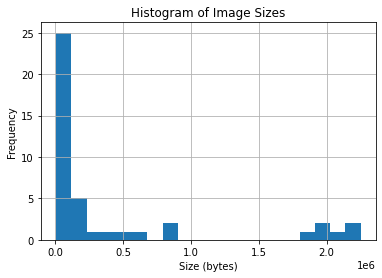

In [27]:
import matplotlib.pyplot as plt

# Plot histogram for image size
image_file_info_df['size'].hist(bins=20)
plt.title('Histogram of Image Sizes')
plt.xlabel('Size (bytes)')
plt.ylabel('Frequency')
plt.show()


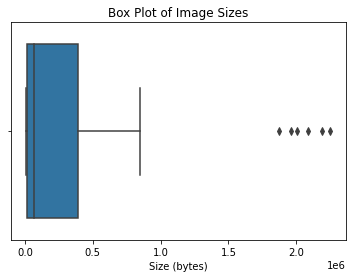

In [28]:
import seaborn as sns

# Box plot for image size
sns.boxplot(x=image_file_info_df['size'])
plt.title('Box Plot of Image Sizes')
plt.xlabel('Size (bytes)')
plt.show()


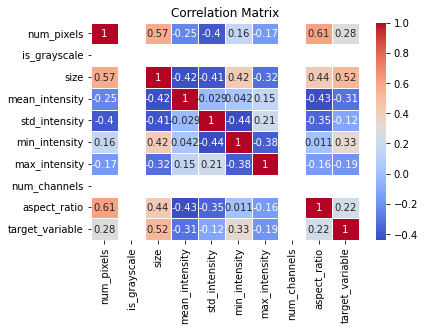

In [29]:
correlation_matrix = image_file_info_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

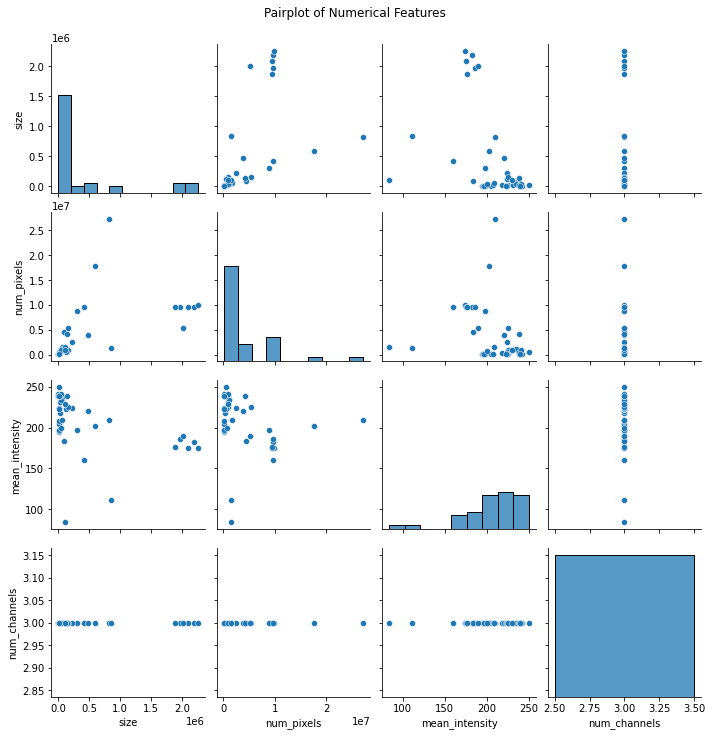

In [30]:
numerical_features = ['size', 'num_pixels', 'mean_intensity', 'num_channels']
sns.pairplot(image_file_info_df[numerical_features])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()


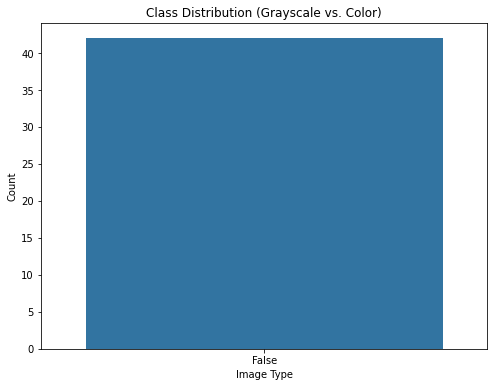

In [31]:
plt.figure(figsize=(8, 6))
sns.countplot(data=image_file_info_df, x='is_grayscale')
plt.title('Class Distribution (Grayscale vs. Color)')
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.show()


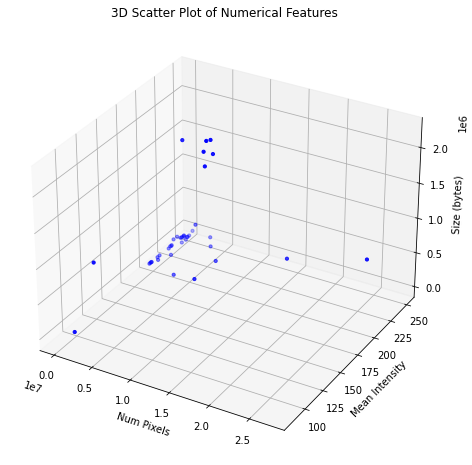

In [32]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(image_file_info_df['num_pixels'], image_file_info_df['mean_intensity'], image_file_info_df['size'], c='blue', s=10)
ax.set_xlabel('Num Pixels')
ax.set_ylabel('Mean Intensity')
ax.set_zlabel('Size (bytes)')

plt.title('3D Scatter Plot of Numerical Features')
plt.show()


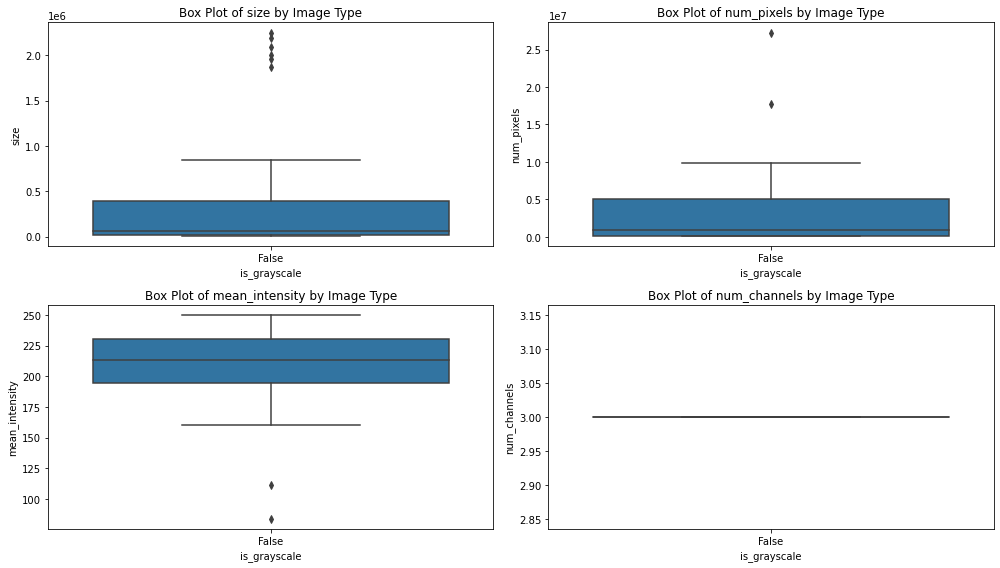

In [33]:
plt.figure(figsize=(14, 8))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=image_file_info_df, x='is_grayscale', y=feature)
    plt.title(f'Box Plot of {feature} by Image Type')

plt.tight_layout()
plt.show()



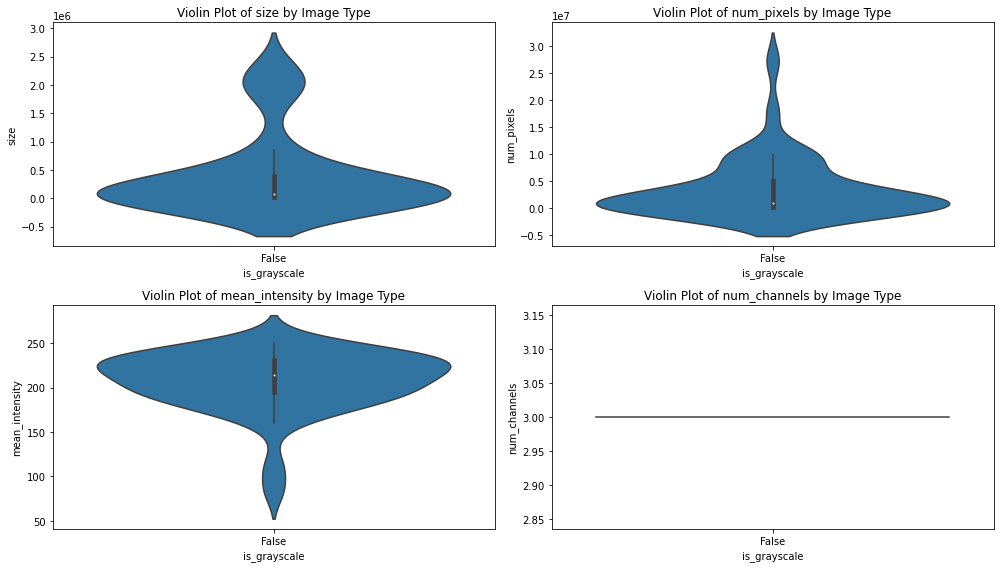

In [34]:
plt.figure(figsize=(14, 8))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(data=image_file_info_df, x='is_grayscale', y=feature)
    plt.title(f'Violin Plot of {feature} by Image Type')

plt.tight_layout()
plt.show()

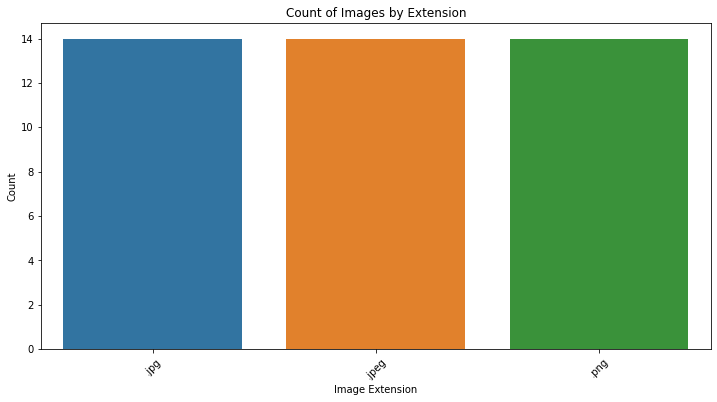

In [35]:
plt.figure(figsize=(12, 6))
sns.countplot(data=image_file_info_df, x='extension')
plt.title('Count of Images by Extension')
plt.xlabel('Image Extension')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

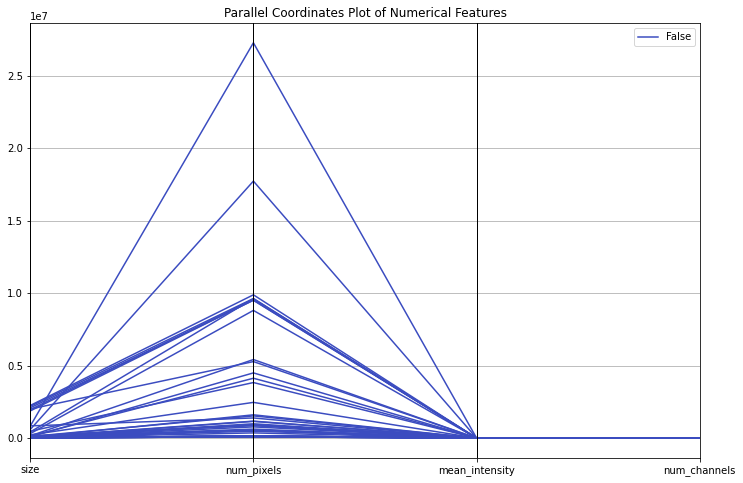

In [36]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(12, 8))
parallel_coordinates(image_file_info_df[numerical_features + ['is_grayscale']], 'is_grayscale', colormap='coolwarm')
plt.title('Parallel Coordinates Plot of Numerical Features')
plt.show()

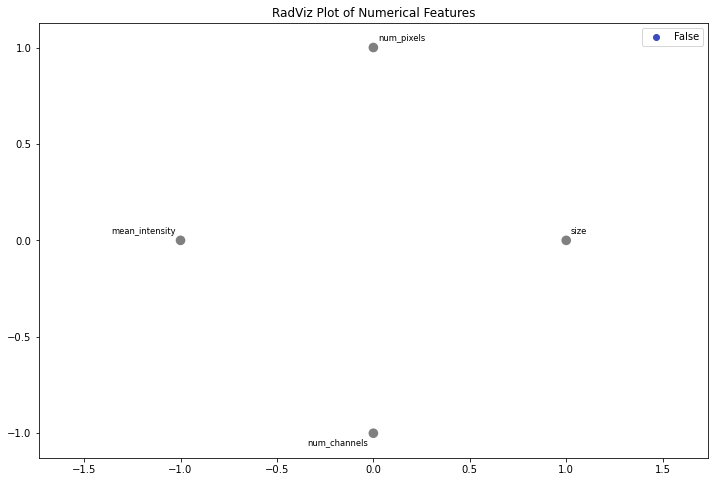

In [37]:
from pandas.plotting import radviz

plt.figure(figsize=(12, 8))
radviz(image_file_info_df[numerical_features + ['is_grayscale']], 'is_grayscale', colormap='coolwarm')
plt.title('RadViz Plot of Numerical Features')
plt.show()

**Natural Language Processing - NLP**

In [38]:
image_file_info_df.head()

,filename,extension,filepath,resolution,num_pixels,is_grayscale,noise,size,mean_intensity,std_intensity,min_intensity,max_intensity,num_channels,dominant_color,aspect_ratio,text,target_variable
0,0001,.jpg,data\images\0001.jpg,"(2955, 2000)",17730000,False,[29.55783589969031],589465,202.173847,38.261689,0,-1,3,"(167, 217, 240)",1.477500,"a\n\nas , HISTORM oO F) AR! (ttME 7. ‘N\n\n——\...",1
1,baba's browser page,.jpeg,data\images\baba's browser page.jpeg,"(177, 284)",150804,False,[23.867786693629224],6542,241.298918,24.138366,0,-1,3,"(255, 255, 255)",0.623239,,0
2,High Court of Lagos State Holden at Lagos on D...,.jpg,data\images\High Court of Lagos State Holden a...,"(3875, 2346)",27272250,False,[28.76593228829025],825542,208.957622,32.867835,0,-1,3,"(193, 229, 235)",1.651748,J ) :\n‘ IN THE HIGH COURT OF LAGOS STATE =\n\...,1
3,land document,.jpeg,data\images\land document.jpeg,"(193, 261)",151119,False,[22.134641845460056],6237,238.323427,25.113684,14,-1,3,"(255, 255, 255)",0.739464,,0
4,Letter from Aje to Omo mi owon. 2.2. 1952-1,.png,data\images\Letter from Aje to Omo mi owon. 2....,"(1989, 1614)",9630738,False,[25.66764635565612],2189399,182.649418,30.718398,16,-1,3,"(165, 195, 213)",1.232342,"beogues 5\n\nUta Nbotebt Stet ,\n\n2{2]o2.\nWi...",2


In [39]:
!pip install nltk

In [40]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

In [41]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Function for text preprocessing
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back to form processed text
    processed_text = ' '.join(tokens)

    return processed_text

# Apply preprocessing to the 'text' column
image_file_info_df['processed_text'] = image_file_info_df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oopli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oopli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
# Display the DataFrame with the processed text column
image_file_info_df[['text', 'processed_text']].head()

,text,processed_text
0,"a\n\nas , HISTORM oO F) AR! (ttME 7. ‘N\n\n——\...",historm oo f ar ttme 7 ‘ n —— — bperensn unt w...
1,,
2,J ) :\n‘ IN THE HIGH COURT OF LAGOS STATE =\n\...,j ‘ high court lago state divorc e suit wd7575...
3,,
4,"beogues 5\n\nUta Nbotebt Stet ,\n\n2{2]o2.\nWi...",beogu 5 uta nbotebt stet 22o2 wisk uxt termi c...


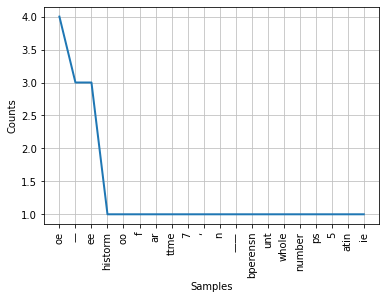

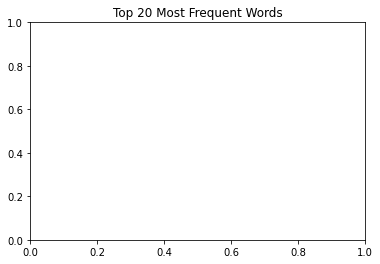

In [43]:
from nltk import FreqDist

# Function to plot word frequency
def plot_word_frequency(text):
    tokens = word_tokenize(text)
    freq_dist = FreqDist(tokens)
    freq_dist.plot(20, cumulative=False)
    plt.title('Top 20 Most Frequent Words')
    plt.show()

# Apply word frequency analysis to a sample
plot_word_frequency(image_file_info_df['processed_text'].iloc[0])

In [44]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Function for sentiment analysis
def perform_sentiment_analysis(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores

# Apply sentiment analysis to a sample
image_file_info_df['sentiment_scores'] = image_file_info_df['processed_text'].apply(perform_sentiment_analysis)
image_file_info_df[['processed_text', 'sentiment_scores']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\oopli\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,processed_text,sentiment_scores
0,historm oo f ar ttme 7 ‘ n —— — bperensn unt w...,"{'neg': 0.0, 'neu': 0.969, 'pos': 0.031, 'comp..."
1,,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound..."
2,j ‘ high court lago state divorc e suit wd7575...,"{'neg': 0.0, 'neu': 0.954, 'pos': 0.046, 'comp..."
3,,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound..."
4,beogu 5 uta nbotebt stet 22o2 wisk uxt termi c...,"{'neg': 0.075, 'neu': 0.925, 'pos': 0.0, 'comp..."


In [45]:
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize
nltk.download('maxent_ne_chunker')
nltk.download('words')

# Function for named entity recognition
def extract_named_entities(text):
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    named_entities = ne_chunk(tagged_words)
    return named_entities

# Apply named entity recognition to a sample
sample_text = image_file_info_df['processed_text'].iloc[0]
named_entities = extract_named_entities(sample_text)
print(named_entities)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\oopli\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\oopli\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  historm/NN
  oo/NN
  f/NN
  ar/NN
  ttme/VBD
  7/CD
  ‘/NNP
  n/JJ
  ——/NNP
  —/NNP
  bperensn/NN
  unt/NN
  whole/JJ
  number/NN
  ps/NN
  5/CD
  atin/NN
  ie/NN
  1/CD
  oe/NN
  ee/NN
  msess/NN
  lin/NN
  gand/NN
  ge/NN
  ee/NN
  del/NN
  oe/JJ
  hath/NN
  —/NNP
  bs/NN
  case/NN
  seth/VBD
  3/CD
  oe/JJ
  oe/RB
  4/CD
  ao/JJ
  inao/NN
  pen/JJ
  che/NN
  yp/NN
  yiaaae/$
  9/CD
  ae/NN
  ma—waek/NN
  gq/NN
  ne/NN
  ose/JJ
  pi/NN
  ee/NN
  that/WDT
  areded/VBD
  —/NN)


**PDF Data Reading/Analysis**

In [46]:
!pip install pdf2image

In [47]:
!pip install PyMuPDF

In [48]:
import fitz  # PyMuPDF

In [49]:
# Function to extract text content from PDF
def get_text_content(doc):
    text_content = ''
    for page_num in range(doc.page_count):
        page = doc[page_num]
        text_content += page.get_text()
    return text_content

# Function to get the number of images in a PDF
def get_num_images(doc):
    num_images = 0
    for page_num in range(doc.page_count):
        page = doc[page_num]
        num_images += len(page.get_images(full=True))
    return num_images

In [50]:
# Function to get PDF information
def get_pdf_info(pdf_path):
    doc = fitz.open(pdf_path)

    # Get basic PDF information
    filename = os.path.splitext(os.path.basename(pdf_path))[0]
    extension = os.path.splitext(pdf_path)[1]
    num_pages = doc.page_count
    size = os.path.getsize(pdf_path)

    # Additional PDF-related information
    text_content = get_text_content(doc)
    num_words = len(text_content.split())
    num_images = get_num_images(doc)


    doc.close()

    return {
        'filename': filename,
        'extension': extension,
        'filepath': os.path.normpath(pdf_path),
        'num_pages': num_pages,
        'size': size,
        'text_content': text_content,
        'num_words': num_words,
        'num_images': num_images
    }



In [51]:

# Directory path
directory_path = './data/pdfs'

# Ensure the directory path is valid
if not os.path.isdir(directory_path):
    print("Invalid directory path.")
else:
    # Initialize an empty list to store file information
    file_info_list = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        pdf_path = os.path.join(directory_path, filename)

        # Check if it's a PDF file
        if os.path.isfile(pdf_path) and pdf_path.lower().endswith('.pdf'):
            # Get PDF information
            pdf_info = get_pdf_info(pdf_path)
            file_info_list.append(pdf_info)

    # Create a DataFrame from the list of file information
    pdf_file_info_df = pd.DataFrame(file_info_list)


In [52]:
# Display the DataFrame
pdf_file_info_df.head()

,filename,extension,filepath,num_pages,size,text_content,num_words,num_images
0,10 Trades Training Regt Re Workshops,.pdf,data\pdfs\10 Trades Training Regt Re Workshops...,2,976240,,0,2
1,An Introduction to Industrial Psychology K.Smith,.pdf,data\pdfs\An Introduction to Industrial Psycho...,1,154845,,0,1
2,Army Form O 1771,.pdf,data\pdfs\Army Form O 1771.pdf,2,722967,,0,2
3,"Bin Card, Army Form G.392B",.pdf,"data\pdfs\Bin Card, Army Form G.392B.pdf",2,604759,,0,2
4,"Bricklayers Tool, 10. 10. 63",.pdf,"data\pdfs\Bricklayers Tool, 10. 10. 63.pdf",1,185764,,0,1


**Saving DataFrames In Excel**

In [53]:
excel_file_path = 'dataframes.xlsx'

# Create an Excel writer object
with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
    # Write each DataFrame to a different sheet
    pdf_file_info_df.to_excel(writer, sheet_name='PDF_Info', index=False)
    image_file_info_df.to_excel(writer, sheet_name='Image_Info', index=False)
    video_file_info_df.to_excel(writer, sheet_name='Video_Info', index=False)

print(f'Excel file "{excel_file_path}" has been created with three sheets.')


Excel file "dataframes.xlsx" has been created with three sheets.


In [54]:
# Generate a report summarizing the findings
def generate_report(dataframes):
    for df in dataframes:
        # Create a simple text-based report
        report = f"{df} Data Analysis Report\n\n"
        report += "Data Columns Info:\n"
        report += str(df.info()) + "\n\n"
        report += "Summary Statistics:\n"
        report += str(df.describe()) + "\n\n"
        report += "Correlation Matrix:\n"
        report += str(df.corr) + "\n"

        # Save the report to a text file
        with open('data_analysis_report.txt', 'w') as file:
            file.write(report)

        print("Data analysis report generated and saved.")
    else:
        print("Analysis results are None. Cannot generate the report.")

all_dataframes = [image_file_info_df,video_file_info_df,pdf_file_info_df]
generate_report(all_dataframes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          42 non-null     object 
 1   extension         42 non-null     object 
 2   filepath          42 non-null     object 
 3   resolution        42 non-null     object 
 4   num_pixels        42 non-null     int64  
 5   is_grayscale      42 non-null     bool   
 6   noise             42 non-null     object 
 7   size              42 non-null     int64  
 8   mean_intensity    42 non-null     float64
 9   std_intensity     42 non-null     float64
 10  min_intensity     42 non-null     int8   
 11  max_intensity     42 non-null     int8   
 12  num_channels      42 non-null     int64  
 13  dominant_color    42 non-null     object 
 14  aspect_ratio      42 non-null     float64
 15  text              42 non-null     object 
 16  target_variable   42 non-null     int8   
 17 